In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
from io import BytesIO


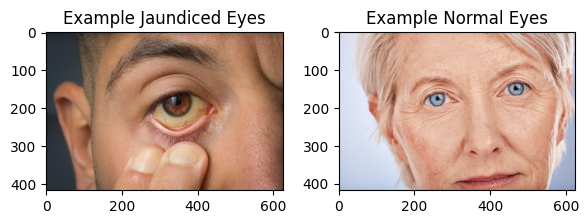

In [3]:
BASE_DIR = "./Data/"
jaundiced_dir = os.path.join(BASE_DIR, "Jaundiced Eyes/")
normal_dir = os.path.join(BASE_DIR, "Normal Eyes/")

fig, axs = plt.subplots(1, 2, figsize=(6, 6))
axs[0].imshow(tf.keras.utils.load_img(f"{os.path.join(jaundiced_dir, os.listdir(jaundiced_dir)[0])}"))
axs[0].set_title('Example Jaundiced Eyes')

axs[1].imshow(tf.keras.utils.load_img(f"{os.path.join(normal_dir, os.listdir(normal_dir)[0])}"))
axs[1].set_title('Example Normal Eyes')

plt.tight_layout()

In [4]:
def training_dataset():
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='./Data/',
        image_size=(150,150),
        batch_size=10,
        label_mode="binary"
    )
    rescale_layer = tf.keras.layers.Rescaling(1./255)
    train_dataset_scaled = train_dataset.map(lambda image, label: (rescale_layer(image), label))
    return train_dataset_scaled

In [5]:
train_data = training_dataset()

for images, labels in train_data.take(1):
    print(f"Range for pixel values: {np.min(images[0]), np.max(images[0])}")

print(f"train_data is an instance of tf.data.Dataset: {isinstance(train_data, tf.data.Dataset)}")

Found 464 files belonging to 2 classes.
Range for pixel values: (0.0, 1.0)
train_data is an instance of tf.data.Dataset: True


In [6]:
def create_and_compile_model():
    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]) 

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        metrics=['accuracy']
    ) 

    return model

In [7]:
model = create_and_compile_model()

In [8]:
training_history = model.fit(
	x=train_data,
    epochs=15,
)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.5387 - loss: 1.6572
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.6881 - loss: 0.6264
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.6210 - loss: 0.6517
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.7308 - loss: 0.5729
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.8183 - loss: 0.4449
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.8596 - loss: 0.3546
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8375 - loss: 0.3170
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.8820 - loss: 0.2392
Epoch 9/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9083 - loss: 0.2264
Epoch 10/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9674 - loss: 0.1052
Epoch 11/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9312 - loss: 0.5695
Epoch 12/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy:

In [ ]:
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

rescale_layer = tf.keras.layers.Rescaling(1./255)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)[0][0]
    
    with out:
        if prediction > 0.5:
            print(filename + " is a jaundiced eye")
        else:
            print(filename + " is a normal eye")


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)
uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()